In this notebook we are going to work with the titanic dataset. The objective is to develop an algorithm that correctly classifies
if a passenger survived or not the titanic collapse. In this case the dependent variable is the binary field Survived. In the dataset
we have different independent fields that help us make the prediction such as the age, sex, class of the ticket, number of sibilings, ticket fare and embarkment class.

In this case we are going to use an ensemble tecnique known as AdaBoost. What this algorithm does is to correct the weights in each iteration on
the data set using as a base estimator other machine learning algorithm. For this project we will use a decision tree as a base estimator.

The first step is to import the required modules available in sklearn and have a look on the data to see if we have to clean or do some data engineering tasks.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import pandas as pd
titanic=pd.read_csv(r'C:\Users\Usuario\Desktop\Data Science\train.csv')

In [2]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


From the previous image we deduce that we don´t need some columns as they are not giving valuable information. The PassengerID
is a number given by the author of the dataset just to index the data so we can remove it. At the same time the name field gives no
no info.To put it in a clearer way you don´t have more chances of surviving the collapse of the titanic if your name was Harris.

We also need to create a dummy variable for the Sex field. With the Embarked variable we will develop a label encoding technique.

So in order to have a clearer picture in mind of we need to do here is a brief resume of the tasks:
    - Remove the PassengerID, Name and Ticket column.
    - Create a dummy variable for the Sex variable.
    - Label encode the Embarked column.

Now we can start:

In [3]:
from sklearn.preprocessing import LabelEncoder
titanic=titanic.drop(['Ticket','PassengerId','Name'],axis=1)
titanic=pd.get_dummies(titanic,columns=['Sex'],drop_first=True)


In [4]:
le=LabelEncoder()
titanic['Embarked']=str(titanic['Embarked'])
titanic['Embarked']=le.fit_transform(titanic['Embarked'])

Once we have done the data engeeniering tasks the next step is to see how many missing and Nan values we have

In [5]:
titanic.isna().sum()


Survived      0
Pclass        0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      0
Sex_male      0
dtype: int64

In [6]:
print('Total number of observations (rows):',len(titanic.index))

Total number of observations (rows): 891


We have 687 missing values for the Cabin field and 177 for the Age one. The best option for the cabin field is to drop the entire
column otherwise we will be loosing important information. With the Age field we would take the normalization approach. We will replace
the missing Age values with the average of the entire set of passengers. This is the best approach taking into account that if we drop
the rows with missing Age field we would be losing almost 20% (177/891) of the data.

In [7]:
titanic=titanic.drop(['Cabin'],axis=1)
titanic['Age']=titanic['Age'].fillna(titanic['Age'].mean())

In [8]:
titanic.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_male
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.0,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.0,0.647587
std,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429,0.0,0.477990
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,0.0,0.000000
50%,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200,0.0,1.000000
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,0.0,1.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,0.0,1.000000


This previous image is a description of the fields already clean. Before the analysis we will continue with some graphs for further
exploration

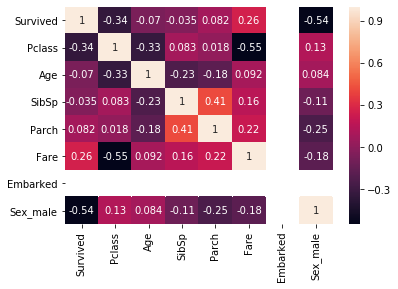

In [14]:
import seaborn as sns
sns.heatmap(titanic.corr(),annot=True)

Survival is strongly negatively correlated with the Passenger Class and being Male. The ticket fare can be also an important factor to 
explain Survival. However, caution is needed as correlation does not mean causation.

It´s time to start developing the AdaBoost algorithm that predicts the Survival or not of a passenger. First we need to divide 
the dataset into a training and a test dataset to see how the algorithm performs in unseen data. 

In [10]:
X=titanic.drop(["Survived"],axis=1)
y=titanic["Survived"]
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=1,test_size=0.3)


Once we have divided the dataset we create the base estimator (a decison tree with max depth one) and the AdaBoost algorithm that
would adjust the weights in each iteration. We train the algorithm in the training data set and then check the accuracy with the roc curve. In simple terms this metric measures the proportion of true positives compared to the false positives.

In [16]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier(max_depth=1,random_state=1)
adb_clf=AdaBoostClassifier(base_estimator=dt,n_estimators=100)
adb_clf.fit(X_train,y_train)
y_pred_proba=adb_clf.predict_proba(X_test)[:,1]
score=roc_auc_score(y_test,y_pred_proba)
print(score)

0.8079140923801119


The accuracy of our algorithm is 80%. Our model would classify correctly 80% of the times if a passenger survived or not. The
visualization of the roc curve would make this point clearer.

Text(0, 0.5, 'True Positives')

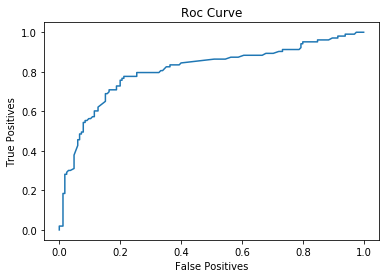

In [12]:
import matplotlib.pyplot as plt
fpr,tpr,treshold=roc_curve(y_test,y_pred_proba)
plt.plot(fpr,tpr)
plt.title('Roc Curve')
plt.xlabel('False Positives')
plt.ylabel('True Positives')

As we can see the percentage of true positives increases up to the 80% from that point onwards the accuracy does not increase and the number of false positives raises. To conclude we can say that the model is accurate. Is out of the scope of this analysis but it would also be interesting to discover
which are the main drivers of survival. 

Thank you for your interest !!

David Lobo